# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn
main_path = '/mnt/raid/ni/agnessa/RSA/'


# Define the function to create filenames

In [2]:
def getFileName(n_samples,name,model_name,layer_name):
    return name \
        + "_{}_".format(n_samples) \
        + "_{}_".format(model_name) \
        + "_{}".format(layer_name)  \
        + ".npy"       

# Average correlation of a subset of layers for two networks (same model, different training tasks) - use the whole matrix (not just upper triangular)

In [3]:
def avg_correlation_cross_task(model_name,trained_on_1,trained_on_2,tested_on,min_layer_idx,max_layer_idx):
    layer_name = 'all'
    
    #define number of samples depending on the testing dataset
    if tested_on == 'ImageNet' or tested_on == '':
        n_samples = 10000
    elif tested_on == 'Places365':
        n_samples = 10220
        
    #load the models
    model_rdm_1_filename = os.path.join(main_path,trained_on_1,'','Model_RDM', \
                                      getFileName(n_samples,'Model_RDM',model_name,layer_name))
    model_name_2 = model_name+'_'+model_name
    model_rdm_2_filename = os.path.join(main_path,trained_on_2,tested_on,'Model_RDM', \
                                      getFileName(n_samples,'Model_RDM_cross_task',model_name_2,layer_name))  
    model_rdm_1 = np.load(model_rdm_1_filename)
    model_rdm_2 = np.load(model_rdm_2_filename)
    
    #select only the desired layers
    selected_model_rdm_1 = model_rdm_1[min_layer_idx:max_layer_idx+1,min_layer_idx:max_layer_idx+1]#plus one makes sure that the last layer is included
    selected_model_rdm_2 = model_rdm_2[min_layer_idx:max_layer_idx+1,min_layer_idx:max_layer_idx+1]
   
    #get the correlation
    avg_correlation_1 = 1-np.mean(selected_model_rdm_1)
    avg_correlation_2 = 1-np.mean(selected_model_rdm_2)
    return avg_correlation_1, avg_correlation_2

In [4]:
r50e1,r50e2 = (avg_correlation_cross_task('resnet50','Objects','Scenes','ImageNet',0,6))
r50l1,r50l2 = (avg_correlation_cross_task('resnet50','Objects','Scenes','ImageNet',7,15))
ane1,ane2 = (avg_correlation_cross_task('alexnet','Objects','Scenes','ImageNet',0,8))
anl1,anl2 = (avg_correlation_cross_task('alexnet','Objects','Scenes','ImageNet',9,20))

print(r50e1,r50e2)
print(r50l1,r50l2)
print(ane1,ane2)
print(anl1,anl2)

0.8302358924957872 0.7865401977739996
0.7438252951049977 0.5654349999732273
0.6144572932756704 0.5630306083774066
0.8024377576838364 0.5301913994149587


# Plot the correlations (bar plot)

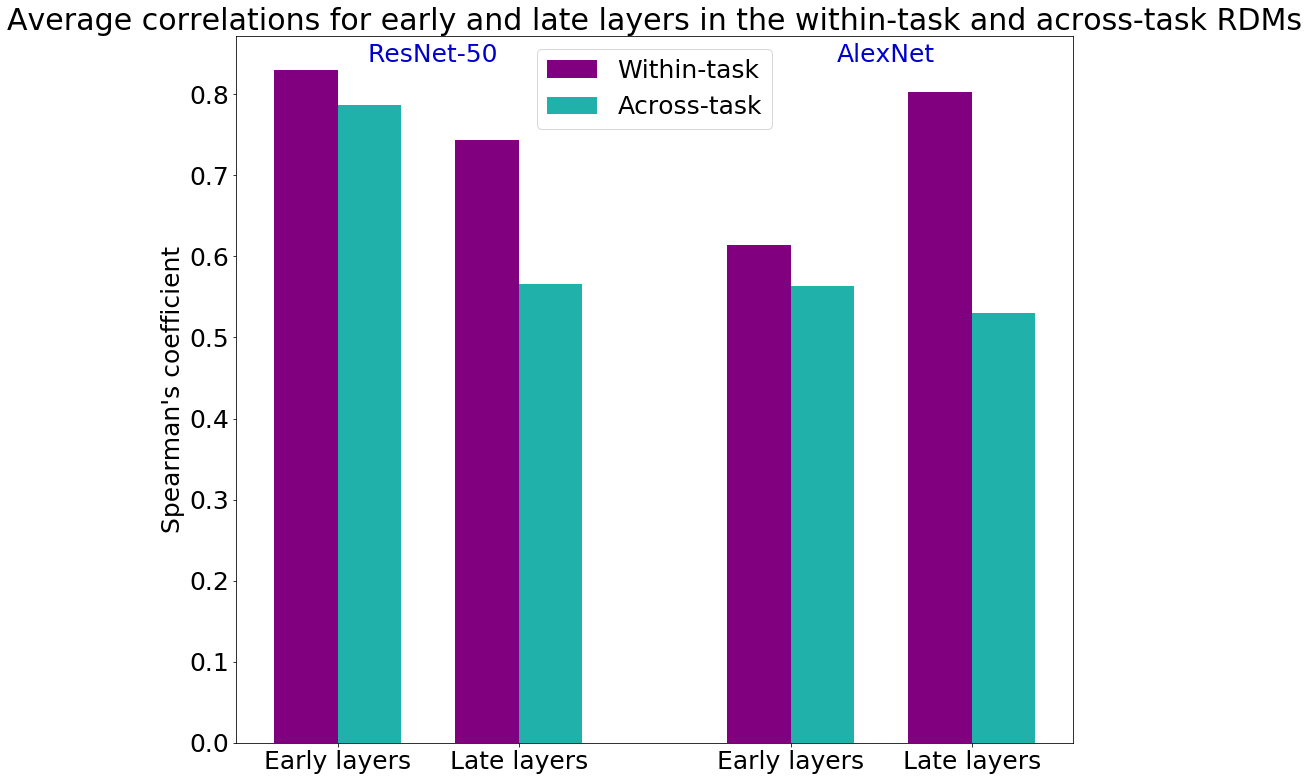

In [6]:
#correlations
within_task_rn = [r50e1,r50l1]
across_tasks_rn = [r50e2,r50l2]
within_task_an = [ane1,anl1]
across_tasks_an = [ane2,anl2]

f, ax = plt.subplots(figsize=(15,13))
num_bars = 2
ind = np.arange(num_bars) 
width = 0.35       

#resnet-50
w_rn = plt.bar(ind, within_task_rn, width, label='Within task', color='purple')
a_rn = plt.bar(ind + width, across_tasks_rn, width, label='Across tasks', color='lightseagreen')

#alexnet50
ind2 = np.arange(num_bars)+2.5
w_an = plt.bar(ind2, within_task_an, width, label='Within task', color='purple')
a_an = plt.bar(ind2 + width, across_tasks_an, width, label='Across tasks', color='lightseagreen')

#plotting parameters
plt.title('Average correlations for early and late layers in the within-task and across-task RDMs',fontsize=30)
plt.ylabel('Spearman\'s coefficient',fontsize=25)
ind3 = np.concatenate([ind,ind2])
plt.xticks(ind3 + width / 2, ('Early layers', 'Late layers','Early layers', 'Late layers'),fontsize=25)
plt.yticks(fontsize=25)
plt.legend([w_rn,a_rn],['Within-task', 'Across-task'],loc='best', fontsize=25)

#model labels
def autolabel(bars, model_name_label, height): 
    """Attach a text label above each quadruplet of bars (in the middle), displaying the model name."""
    for b in bars:
        if bars.index(b)==0:
            ax.annotate('{}'.format(model_name_label),
                        xy=(b.get_x() + b.get_width()*2.5, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=25,
                        color='mediumblue')
            xy=(b.get_x() + b.get_width()*2.5, height)


    
#get the max height of the bars to label the model name above it    
all_corr = np.concatenate([within_task_rn,across_tasks_rn,within_task_an,across_tasks_an])
max_height = max(all_corr)

autolabel(w_rn,'ResNet-50',max_height)
autolabel(w_an,'AlexNet',max_height)

plt.show()

#save
                                 

In [52]:
def bar_plot_correlations(**kwargs):
    #setup the figure
    f, ax = plt.subplots(figsize=(15,13))
    num_bars = 2
    ind = np.arange(num_bars) 
    width = 0.35       
    x_all = np.ones((len(kwargs),num_bars))
    
    #loop over models
    for index,k in enumerate(kwargs):
        correlations = kwargs.get(k)
        x = np.arange(num_bars)+2.5*index
        within_task = plt.bar(x, correlations[0,:], width, label='Within task', color='purple')
        across_tasks = plt.bar(x + width, correlations[1,:], width, label='Across tasks', color='lightseagreen')
        x_all[index,:] = x
    
#     flattened_x_all = x_all.flatten()
    #plotting parameters
    font_small = 25
    font_title = 30
    plt.title('Average correlations for early and late layers in the within-task and across-task RDMs',fontsize=font_title)
    plt.xticks(x_all.flatten() + width / 2, ('Early layers', 'Late layers','Early layers', 'Late layers'),fontsize=font_small)
    plt.yticks(fontsize=font_small)
    plt.ylabel('Spearman\'s coefficient',fontsize=font_small)
    plt.legend([within_task,across_tasks],['Within-task', 'Across-task'],loc='best', fontsize=font_small) #can do it for just one of the 

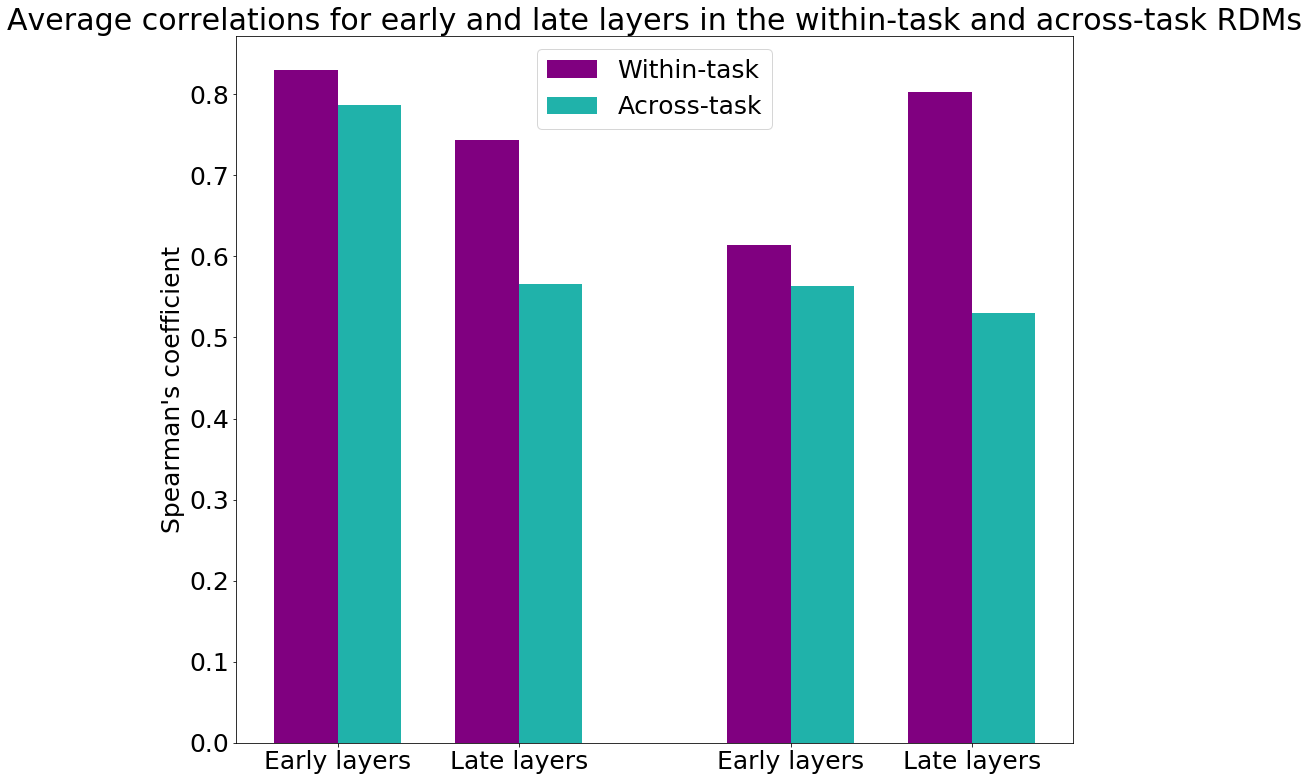

In [53]:
bar_plot_correlations(corr_model_1=np.array([within_task_rn,across_tasks_rn]), 
                      corr_model_2=np.array([within_task_an,across_tasks_an]))

In [ ]:

# #plotting parameters
# plt.title('Average correlations for early and late layers in the within-task and across-task RDMs',fontsize=30)
# plt.ylabel('Spearman\'s coefficient',fontsize=25)
# ind3 = np.concatenate([ind,ind2])
# plt.xticks(ind3 + width / 2, ('Early layers', 'Late layers','Early layers', 'Late layers'),fontsize=25)
# plt.yticks(fontsize=25)
# plt.legend([w_rn,a_rn],['Within-task', 'Across-task'],loc='best', fontsize=25)

# #model labels
# def autolabel(bars, model_name_label, height): 
#     """Attach a text label above each quadruplet of bars (in the middle), displaying the model name."""
#     for b in bars:
#         if bars.index(b)==0:
#             ax.annotate('{}'.format(model_name_label),
#                         xy=(b.get_x() + b.get_width()*2.5, height),
#                         xytext=(0, 3),  # 3 points vertical offset
#                         textcoords="offset points",
#                         ha='center', va='bottom',
#                         fontsize=25,
#                         color='mediumblue')
#             xy=(b.get_x() + b.get_width()*2.5, height)


    
# #get the max height of the bars to label the model name above it    
# all_corr = np.concatenate([within_task_rn,across_tasks_rn,within_task_an,across_tasks_an])
# max_height = max(all_corr)

# autolabel(w_rn,'ResNet-50',max_height)
# autolabel(w_an,'AlexNet',max_height)

# plt.show()

# #save

TypeError: descriptor 'append' requires a 'list' object but received a 'int'